In [1]:
import sys

sys.path.append('../..')
sys.path

['/opt/anaconda/envs/diffLIME/lib/python39.zip',
 '/opt/anaconda/envs/diffLIME/lib/python3.9',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/setuptools/_vendor',
 '../..']

In [2]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [5]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


In [6]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]

Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Extracting files CWRU...


In [7]:
from phm_framework.data import prepare_data

X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
#_xmin, _xmax = X_train.min(axis=1), X_train.max(axis=1)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)

#X_train = ((X_train.T - _xmin) / (_xmax - _xmin)).T
#M_train = (M_train - _mmin) / (_mmax - _mmin)

X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)

#_xmin, _xmax = X_val.min(axis=1), X_val.max(axis=1)
#X_val = ((X_val.T - _xmin) / (_xmax - _xmin)).T
#M_val = (M_val - _mmin) / (_mmax - _mmin)


In [8]:
from phm_framework.data import synthetic
from importlib import reload
reload(synthetic)

(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
M[plot_idxs].shape

(14, 8)

In [ ]:
from phm_framework.nets import dpm 
reload(dpm)

meta_att = ['periodicity', 'stability', 'oscilation', 'complexity', 'noise', 'informative', 'variability',
            'standard_deviation', 'peculiarity', 'dynamic_range', 'simetry', 'peaks', 'slope', 'f1', 'f2', 'f3']

meta_att = [f"att{i}" for i in range(M.shape[1])]

model = dpm.DiffusionModel(X.shape[1],
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)



model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=tf.keras.losses.MeanAbsoluteError(),
    run_eagerly=False
)

es = tf.keras.callbacks.EarlyStopping(monitor='val_signal_loss', patience=8)

plot_idxs = np.random.uniform(0, X.shape[0], 14).astype(int)

def plotting(*args, **kwargs):
    return model.plot_images(np.expand_dims(X[plot_idxs], axis=-1), 
                           np.expand_dims(M[plot_idxs], axis=-1), 
                           *args, **kwargs)

pi = tf.keras.callbacks.LambdaCallback(on_epoch_end=plotting),
                

model.fit(
    (np.expand_dims(X, axis=-1), np.expand_dims(M, axis=-1)),
    epochs=2000,
    batch_size=32,
    steps_per_epoch=100,
    verbose=2,
    validation_data=(np.expand_dims(X, axis=-1)[:128], np.expand_dims(M, axis=-1)[:128]),
    callbacks=[pi]
)



Epoch 1/2000


In [30]:
type(model.internal_logs)

keras.src.utils.tracking.TrackedDict

In [354]:
so = np.expand_dims(X_train[3000], axis=[0, -1])

frec1 = 0.5 * np.pi
frec2 = 0.9 * np.pi
pend = 0.01
time = np.linspace(0, 10, X_train[3000].shape[0])
so = np.sin(frec1 * time) + np.sin(frec2 * time)  # Sinusoidal signal
so = ajustar_pendiente_y_escalar(so, pend)
#so = (so - so.min()) / (so.max() - so.min())
so = np.expand_dims(so, axis=[0, -1])



(1, 7, 1)


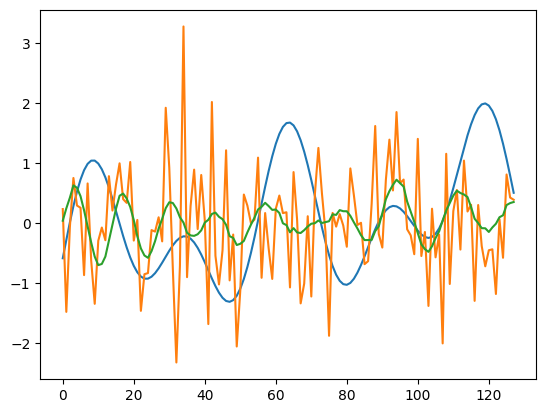

In [356]:
sini = np.random.normal(size=(1, X_train.shape[1], 1)) 

plt.plot(so[0, :, 0])
plt.plot(sini[0, :, 0])

f = np.expand_dims(np.array([frec1, frec2, 10*pend, np.std(so), 0.3, 0, 0.5]).T, axis=[0, -1])
print(f.shape)    
    
N = 40
s = sini
n = 1 / N
r = np.array([[n]])
for i in range(N, 0,  -1):
    
    t = np.array([[i]])

    network = dpm.network
    _input = dpm.prepare_inputs(s, f, t)
    pred_noises = dpm.network(_input, training=False)


    s = s - pred_noises
    
    #pred_samples = self.decode_samples(noisy_samples, pred_noises, noise_rates)

    #_, s = dpm.denoise(s, r, m, t, False)

#plt.plot(pred_noises[0, :, 0])   

s = s[0, :, 0].numpy()
#s = (s - s.min()) / (s.max() - s.min())
plt.plot(s) 




In [353]:
f

array([[[array([2.84670297, 1.87890007, 3.05340441, ..., 2.72827043, 1.84777052,
       2.9128639 ])],
        [array([0.14724834, 0.59335451, 1.35970624, ..., 0.64783784, 1.19249733,
       2.36872232])],
        [array([-0.95493593,  0.4794201 ,  0.35002947, ..., -0.04062877,
        0.22230965,  0.6921541 ])],
        [0.8971566871263215],
        [0.3],
        [-1.314761298381499],
        [1.9918991081858684]]], dtype=object)

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def ajustar_pendiente_y_escalar(serie_temporal, pendiente_objetivo, tiempo=None):
    """
    Ajusta una serie temporal para que su pendiente de regresión sea la indicada,
    y escala los valores para que los máximos y mínimos coincidan con la serie original.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal original (1D).
        pendiente_objetivo (float): Pendiente deseada para la línea de regresión.
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usará un índice lineal.

    Returns:
        numpy.ndarray: Serie temporal ajustada y escalada.
    """
    # Generar tiempo si no está dado
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Calcular la pendiente actual usando regresión lineal
    tiempo = tiempo.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(tiempo, serie_temporal)
    pendiente_actual = reg.coef_[0]
    
    # Calcular el ajuste necesario
    ajuste_pendiente = pendiente_objetivo - pendiente_actual
    
    # Modificar la serie para lograr la pendiente deseada
    serie_ajustada = serie_temporal + ajuste_pendiente * (tiempo.flatten() - tiempo.mean())
    
    # Escalar la serie ajustada para que sus máximos y mínimos coincidan con los originales
    min_original, max_original = serie_temporal.min(), serie_temporal.max()
    min_ajustada, max_ajustada = serie_ajustada.min(), serie_ajustada.max()
    
    # Escalamiento lineal
    serie_escalada = ((serie_ajustada - min_ajustada) / (max_ajustada - min_ajustada)) * (max_original - min_original) + min_original
    
    return serie_escalada


def extraer_envolventes(serie_temporal, tiempo=None):
    """
    Extrae las envolventes superior e inferior de una serie temporal.

    Args:
        serie_temporal (numpy.ndarray): Serie temporal (1D).
        tiempo (numpy.ndarray, opcional): Tiempos asociados a la serie. Si no se especifica, se usa un índice lineal.

    Returns:
        tuple: (envolvente_superior, envolvente_inferior)
    """
    if tiempo is None:
        tiempo = np.arange(len(serie_temporal))
    
    # Encontrar picos máximos (envolvente superior)
    picos_superior, _ = find_peaks(serie_temporal)
    # Encontrar picos mínimos (envolvente inferior)
    picos_inferior, _ = find_peaks(-serie_temporal)
    
    # Interpolación para generar las envolventes
    interp_superior = interp1d(tiempo[picos_superior], serie_temporal[picos_superior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    interp_inferior = interp1d(tiempo[picos_inferior], serie_temporal[picos_inferior], 
                               kind="linear", bounds_error=False, fill_value="extrapolate")
    
    envolvente_superior = interp_superior(tiempo)
    envolvente_inferior = interp_inferior(tiempo)
    
    return envolvente_superior, envolvente_inferior


In [8]:
N = 10000
time = np.linspace(0, 10, 128)
frec1 = np.random.uniform(0.1, 1, N) * np.pi
frec2 = np.random.uniform(0.1, 1, N) * np.pi
pend = np.random.uniform(-0.1, 0.1, N) 
noise = np.random.uniform(0, 1, N) 

X_sin = np.array([time] * N)

for i, (f1, f2, p, n) in enumerate(zip(frec1, frec2, pend, noise)):
    s = np.sin(X_sin[i] * 2 * f1)  + np.sin(X_sin[i] * 2 * f2)
    s = ajustar_pendiente_y_escalar(s, p)
    s = s + np.random.normal(size=s.shape) * n 
    X_sin[i] = s

frec = np.array([frec1, frec2, pend * 10, np.std(X_sin, axis=1), noise, X_sin.min(axis=1), X_sin.max(axis=1)]).T

In [9]:
envolventes  = [extraer_envolventes(X_sin[i]) for i in range(X_sin.shape[0])]

/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


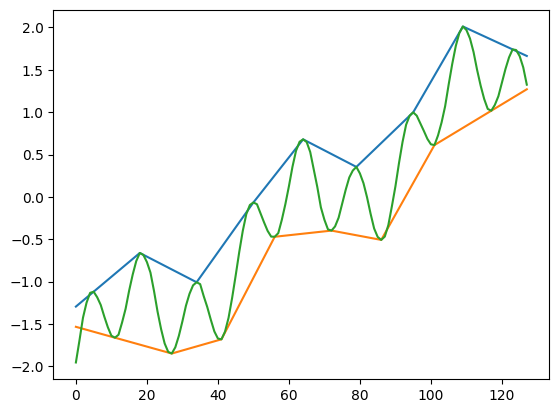

In [10]:
n = 180
plt.plot(envolventes[n][0])
plt.plot(envolventes[n][1])
plt.plot(X_sin[n])

In [415]:
from phm_framework.nets.vae  import VariationalAutoencoder

vae = VariationalAutoencoder(
    eta=1, alpha=0.001, loss_type='mse',
    input_dim=(128, 1),
    encoder_conv_filters=[32, 64, 64, 64, 64, 64],
    encoder_conv_kernel_size=[5, 5, 5, 5, 5, 5],
    encoder_conv_strides=[1, 2, 2, 2, 2, 1],
    decoder_conv_filters=[64, 64, 32, 32, 32, 1],
    decoder_conv_kernel_size=[3, 3, 3, 3, 3, 3],
    decoder_conv_strides=[1, 2, 2, 2, 2, 1],
    activation=tf.keras.layers.LeakyReLU(),
    use_batch_normalization=True,
    z_dim=10
)

X = np.expand_dims(np.array(envolventes)[:, 0], axis=-1)
V = np.expand_dims(np.array(envolventes)[:, 1], axis=-1)
vae.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse',
                     metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mapes")])
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
vae.fit(X, X, epochs=100, verbose=2, batch_size=64,
                 callbacks=[es]
       )


Epoch 1/100
305/305 - 6s - loss: 0.4633 - reconstruction_loss: 0.4293 - kl_loss: 34.0488
Epoch 2/100
305/305 - 3s - loss: 0.2413 - reconstruction_loss: 0.2159 - kl_loss: 25.4228
Epoch 3/100
305/305 - 3s - loss: 0.2329 - reconstruction_loss: 0.2088 - kl_loss: 24.1125
Epoch 4/100
305/305 - 3s - loss: 0.2302 - reconstruction_loss: 0.2065 - kl_loss: 23.7428
Epoch 5/100
305/305 - 3s - loss: 0.2288 - reconstruction_loss: 0.2052 - kl_loss: 23.5391
Epoch 6/100
305/305 - 3s - loss: 0.2281 - reconstruction_loss: 0.2047 - kl_loss: 23.3903
Epoch 7/100
305/305 - 3s - loss: 0.2273 - reconstruction_loss: 0.2041 - kl_loss: 23.2569
Epoch 8/100
305/305 - 3s - loss: 0.2270 - reconstruction_loss: 0.2038 - kl_loss: 23.2116
Epoch 9/100
305/305 - 4s - loss: 0.2266 - reconstruction_loss: 0.2035 - kl_loss: 23.1308
Epoch 10/100
305/305 - 5s - loss: 0.2267 - reconstruction_loss: 0.2036 - kl_loss: 23.0599
Epoch 11/100
305/305 - 4s - loss: 0.2264 - reconstruction_loss: 0.2034 - kl_loss: 22.9845
Epoch 12/100
305/30

KeyboardInterrupt: 

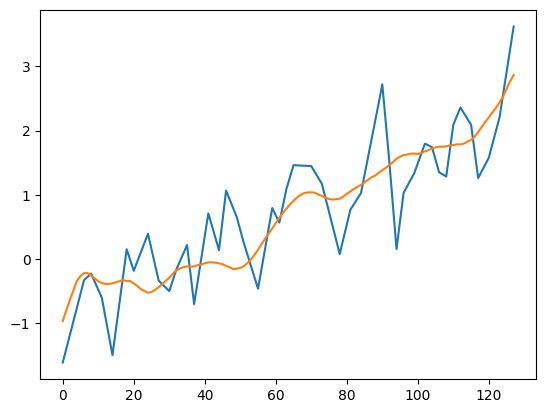

In [416]:
plt.plot(X[0])
plt.plot(vae.predict(X[0:1])[0])

/home/dasolma/miniconda3/envs/phm_framework_gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


finalizado


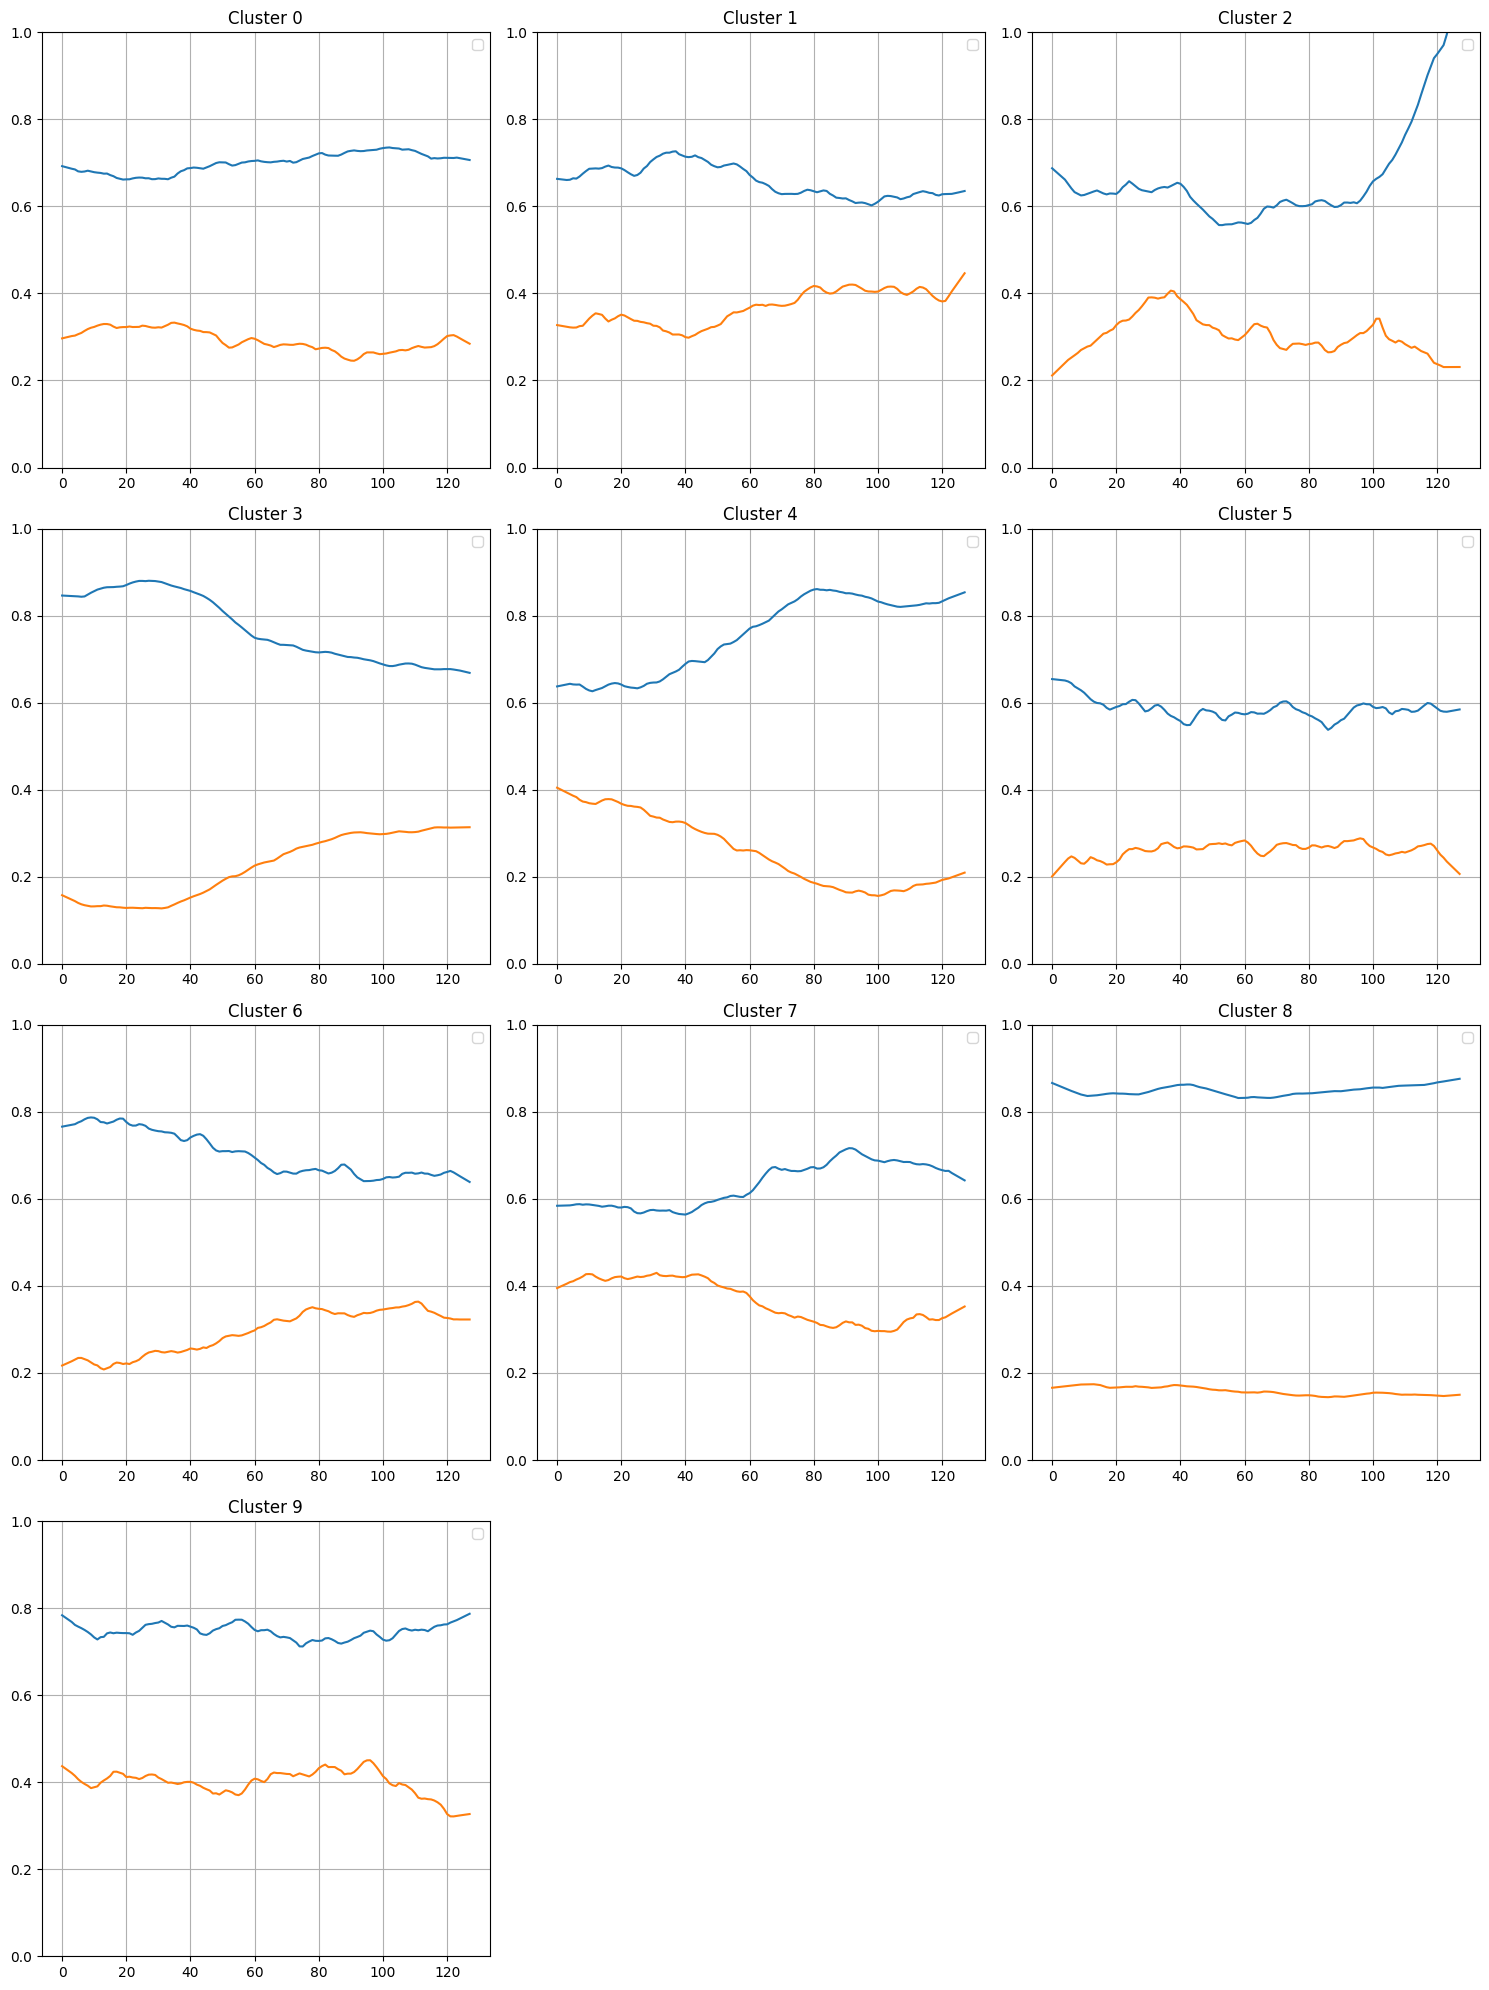

In [90]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
import numpy as np
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate

def sbd(x, y):
    """
    Shape-Based Distance (SBD) entre dos series temporales.
    Se basa en la normalización de la correlación cruzada.
    """
    # Correlación cruzada normalizada
    correlation = correlate(x - np.mean(x), y - np.mean(y), mode='full')
    correlation = correlation / (np.linalg.norm(x) * np.linalg.norm(y))
    
    # La SBD es 1 menos la máxima correlación
    return 1 - np.max(correlation)

def dtw_distance_matrix(X):
    """
    Calcula la matriz de distancias utilizando DTW (Dynamic Time Warping).
    """
    n = len(X)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist_matrix[i, j] = dist_matrix[j, i] = dtw(X[i], X[j])  # Usando DTW de tslearn
    return dist_matrix

def sbd_distance_matrix(X):
    """
    Calcula la matriz de distancias utilizando Shape-Based Distance (SBD).
    """
    n = len(X)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            dist_matrix[i, j] = dist_matrix[j, i] = sbd(X[i], X[j])  # Usando SBD
    return dist_matrix

def calculate_centroids(X, labels, n_clusters, metric='dtw'):
    """
    Calcula los centroides de los clusters utilizando la métrica personalizada.
    
    Args:
        X (numpy.ndarray): Matriz de series temporales (n_series x n_timestamps).
        labels (numpy.ndarray): Etiquetas de los clusters.
        n_clusters (int): Número de clusters.
        metric (str): La métrica a usar ('dtw' o 'sbd').
    
    Returns:
        centroids (list): Una lista de los centroides de los clusters.
    """
    centroids = []
    for i in range(n_clusters):
        # Seleccionamos las series pertenecientes al cluster i
        cluster_series = X[labels == i]
        
        centroids.append(cluster_series.mean(axis=0))
    
    return np.array(centroids)

def clusterizar_series_temporales(series_temporales, n_clusters=3, metric='dtw'):
    """
    Realiza el clustering de series temporales usando KMeans y una métrica personalizada (DTW o SBD).
    
    Args:
        series_temporales (numpy.ndarray): Matriz de series temporales (n_series x n_timestamps).
        n_clusters (int): Número de clusters a formar.
        metric (str): La métrica a usar ('dtw' o 'sbd').
    
    Returns:
        labels (numpy.ndarray): Etiquetas de los clusters asignadas a cada serie temporal.
        centroids (numpy.ndarray): Los centroides de los clusters.
    """
    # Calcular la matriz de distancias según la métrica seleccionada
    if metric == 'dtw':
        dist_matrix = dtw_distance_matrix(series_temporales)
    elif metric == 'sbd':
        dist_matrix = sbd_distance_matrix(series_temporales)
    else:
        raise ValueError("Métrica no soportada. Usa 'dtw' o 'sbd'.")
    
    # Aplicar KMeans sobre la matriz de distancias
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(dist_matrix)
    
    # Obtener etiquetas de los clusters
    labels = kmeans.labels_
    
    # Calcular los centroides
    centroids = calculate_centroids(series_temporales, labels, n_clusters, metric)
    
    return labels, centroids

def plot_clusters(series_temporales, labels, centroids, n_clusters):
    """
    Dibuja los clusters con una cuadrícula de 3 columnas y N filas.

    Args:
        series_temporales (numpy.ndarray): Array de series temporales.
        labels (numpy.ndarray): Etiquetas de los clusters.
        centroids (numpy.ndarray): Centroides de los clusters.
        n_clusters (int): Número de clusters.
    """
    # Determinar el número de filas y columnas
    n_cols = 3
    n_rows = int(np.ceil(n_clusters / n_cols))

    plt.figure(figsize=(15, n_rows * 5))  # Ajustar tamaño según filas

    for cluster_idx in range(n_clusters):
        plt.subplot(n_rows, n_cols, cluster_idx + 1)  # Configurar subplot
        #for i, series in enumerate(series_temporales):
        #    if labels[i] == cluster_idx:
        #        if len(series.shape) > 2:
        #            plt.plot(series[0, :], alpha=0.6, label=f"Serie {i}")
        #            plt.plot(series[1, :], alpha=0.6, label=f"Serie {i}")
        #        else:
        #            plt.plot(series, alpha=0.6, label=f"Serie {i}")
        #plt.plot(centroids[cluster_idx].ravel(), color="black", linewidth=2, label="Centroide")
        plt.plot(centroids[cluster_idx, 0, :])
        plt.plot(centroids[cluster_idx, 1, :])
        plt.title(f"Cluster {cluster_idx}")
        plt.ylim(0, 1)
        plt.legend(loc="upper right")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
n_timestamps = 100
np.random.seed(42)

# Generar series temporales aleatorias
N  = 1000
np.random.shuffle(envolventes)
series_temporales = np.abs(np.array(envolventes)[:N, 0] -  np.array(envolventes)[:N, 1])
series_temporales = np.array(envolventes)[:N, 0]

series_temporales = np.array(envolventes)[:N, :, :]


# Aplicar clustering con K-means y DTW
n_clusters = 10
labels, centroids = clusterizar_series_temporales(series_temporales, n_clusters, metric='dtw')
print("finalizado")
# Dibujar clusters
plot_clusters(series_temporales, labels, centroids, n_clusters)

In [38]:
envolventes  = [extraer_envolventes(X_train[i]) for i in range(X_train.shape[0])]

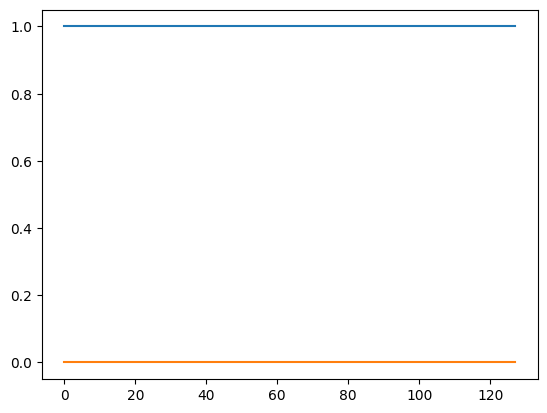

In [87]:
plt.plot(centroids[6, 0, :])
plt.plot(centroids[6, 1, :])

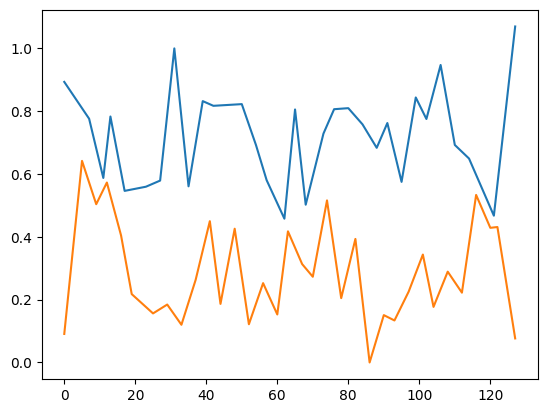

In [79]:
plt.plot(series_temporales[50, 0, :])
plt.plot(series_temporales[50, 1, :])